In [1]:
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("Linear.jl")

forward_aug (generic function with 1 method)

# High Dimensional Elliptic Equation : Optimization Approach

Consider the one dimensional elliptic equation
\begin{equation*}
\begin{split}
&-\frac{d^2 \theta}{dx^2} + \theta  = f(x), \\
&\theta(0) = \theta(1) = 0.
\end{split}
\end{equation*}
Here  Dirichlet boundary conditions are applied on both ends, and $f$ defines the source:
\begin{align*}
    f(x) = \begin{cases}
               1 & 0 \leq x\leq \frac{1}{2}\\
               2 & \frac{1}{2} < x \leq 1\\
            \end{cases}. 
\end{align*}

The elliptic equation is semi-discretized by finite difference method on a uniform grid with $N_{\theta}+2$ points with $N_{\theta} = 1000$. 
The solution is $\theta_{ref} \in \mathcal{R}^{N_{\theta}}$ on these interior points.
We are interested in the inverse problem of recovering $\theta_{ref}$ from observations of $f$ on these interior points ($N_y = N_\theta$):
\begin{equation*}
    y =  G\theta + \eta,
\end{equation*}
here $\displaystyle G = (-\frac{d^2}{dx^2} + 1)$ is the discretized operator, the observation error is $\eta \sim \mathcal{N}(0, I) \in \mathcal{R}^{N_y}$. 

In [2]:
function Elliptic(N_θ::Int64)    
    h = 1/(N_θ + 1)
    
    G = Tridiagonal(fill(-1.0/h^2, N_θ-1), fill(1+2.0/h^2, N_θ), fill(-1.0/h^2, N_θ-1));
    
    x = LinRange(h, 1-h, N_θ)
    
    y = fill(1.0, N_θ)
    y[1:div(N_θ,2)] .= 2.0
    θ_ref = G\y
     
    Σ_η = Diagonal(fill(1.0^2, N_θ))
    
    return θ_ref, G, y, Σ_η, x
end

Elliptic (generic function with 1 method)

## Low-Rank Kalman Inversion

Since the large structure of $\theta$ lies in the Fourier sine space, we can approximate it as 
$$
    \theta = \tau_{(1)}\sin(x\pi)+\,\cdots\, + \tau_{(N_r)} \sin(N_rx\pi) \quad \textrm{  with  } \quad N_r = 5.
$$

For UKI, the reparameterization is used and the UKI is initialized with $\tau_0 \sim \mathcal{N}(0,10^2 I)$. 
For EKI, EAKI, and ETKI, the initial ensembles are generated from the distribution $\mathcal{N}(0, Z_0 Z_0^T)$, which span the column space of $Z_0$, where 

$$
    Z_0 = 10\times\Big(\sin(x\pi)\quad \sin(2x\pi)\quad\cdots \quad\sin(N_rx\pi)\Big).
$$

The ensemble size is $J= 2N_r+1$, which matches the number of $\sigma$-points of UKI. 


The convergence of $\{m_n\}$ in terms of the relative $L_2$ norm errors is depicted in \cref{fig:Low-rank-linear}. All the Kalman inversions behave similar and converge efficiently, although the EKI suffers from random noise due to the small ensemble size. This problem illustrates how UKI uses $2N_r+1 = 11$ $\sigma$-points to solve a $N_{\theta}=1000$ dimensional inverse problem.

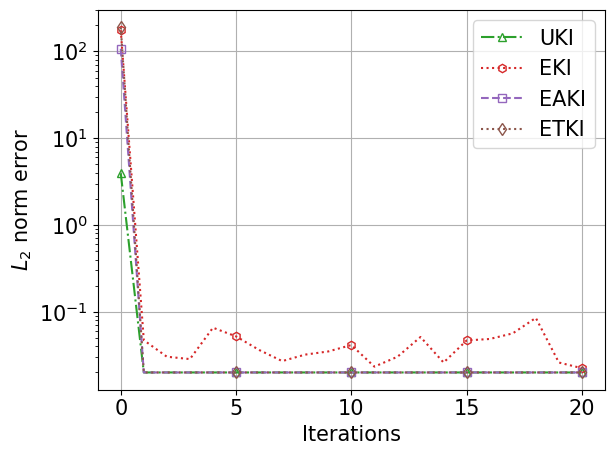

┌ Info: ("Start ", "EKI", " on the regularized stochastic dynamical system for optimization ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:95
┌ Info: ("Start ", "EAKI", " on the regularized stochastic dynamical system for optimization ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:95
┌ Info: ("Start ", "ETKI", " on the regularized stochastic dynamical system for optimization ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:95
┌ Info: Start UKI on the regularized stochastic dynamical system for optimization 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:483


In [6]:
N_θ = 1000
θ_ref, G, y, Σ_η, x = Elliptic(N_θ)

N_y = length(y)

s_param = Setup_Param(G, N_θ, N_y)



α_reg = 1.0
update_freq = 0
N_iter = 20
N_r = 5
N_ens = 2N_r + 1

θ0_mean = zeros(Float64, N_θ)  # mean 
θθ0_cov_sqrt = ones(Float64, N_θ, N_r)
for i = 1:N_r
    θθ0_cov_sqrt[:, i] = 10.0 * sin.(i *  pi*x) 
end

θ0_mean_r = zeros(Float64, N_r)  # mean , 
θθ0_cov_r =  Array(Diagonal(fill(10.0^2, N_r)))
θ_basis = zeros(Float64, N_r, N_θ)
for i = 1:N_r
    θ_basis[i,:] = sin.(i *  pi*x) 
end

# 
γ = 2.0
# EKI 
eki_obj = EKI_Run(s_param, forward, "EKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, y, Σ_η, γ,  α_reg, update_freq, N_iter)
# EAKI
eaki_obj = EKI_Run(s_param, forward, "EAKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)
# ETKI
etki_obj = EKI_Run(s_param, forward,  "ETKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, y, Σ_η, γ, α_reg, update_freq, N_iter)

uki_obj = UKI_Run(s_param, forward, θ0_mean_r, θθ0_cov_r, θ0_mean_r, θθ0_cov_r, y, Σ_η, γ, α_reg, update_freq, N_iter; unscented_transform="modified-2n+1", θ_basis = θ_basis)


ites = Array(LinRange(0, N_iter, N_iter+1))
uki_errors = zeros(Float64, N_iter+1)
eki_errors = zeros(Float64, N_iter+1)
eaki_errors = zeros(Float64, N_iter+1)
etki_errors = zeros(Float64, N_iter+1)
for i = 1:N_iter+1
    eki_errors[i]  = norm(dropdims(mean(eki_obj.θ[i], dims=1), dims=1) .- θ_ref)
    eaki_errors[i] = norm(dropdims(mean(eaki_obj.θ[i], dims=1), dims=1) .- θ_ref)
    etki_errors[i] = norm(dropdims(mean(etki_obj.θ[i], dims=1), dims=1) .- θ_ref)
    uki_errors[i]  = norm(θ_basis' * uki_obj.θ_mean[i]   - θ_ref)
end


markevery =5


semilogy(ites, uki_errors, "-.^",  color="C2", fillstyle="none", markevery=markevery, label= "UKI")
semilogy(ites, eki_errors, ":h",  color="C3", fillstyle="none", markevery=markevery, label= "EKI")
semilogy(ites, eaki_errors, "--s",  color="C4", fillstyle="none", markevery=markevery, label= "EAKI")
semilogy(ites, etki_errors, ":d",  color="C5", fillstyle="none", markevery=markevery, label= "ETKI")


xlabel("Iterations")
ylabel("\$L_2\$ norm error")
grid("on")
legend()
tight_layout()


